# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [3]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [4]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [5]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [70]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, seed=None, std=False):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean()
            std = train_data.std()
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv

In [7]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [8]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [9]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [10]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [11]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [75]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage=0.8, f_eta=None, std=False, v=True):
    if f_eta is None:
        return lambda x: x
    
    data = buildTrain(X, y, percentage, std)
    n_features = X.shape[1]
    n_classes = len(data.get_train()[1].unique())
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        

    
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [13]:
def train_perc_cold(perc, X, y, percentage=0.8, max_iter= 5000, std=False):
    data = buildTrain(X, y, percentage, std)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [168]:
class perc():
    def __init__(self, seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
            
    def train(self, X, y, percentage=0.8, std=False, loss = 'log', penalty = 'none', alpha = 0.0001, power_t = 0.5, 
               max_iter = 5000, it_interval = 100, threshold_unbalanced=0.6, class_weight=None, 
               learning_rate='invscaling', eta0=1e-2):
        
        warm_start = True
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')
            
        unbalanced = False
        
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if class_weight is None:
                
                d_cat = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                class_weight = d_cat
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in d_cat})
            unbalanced = True
                
            
        #compute epochs
        epochs = max_iter // it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(loss=loss, penalty=penalty, max_iter=it_interval,
                             alpha=alpha, learning_rate=learning_rate, eta0=eta0,
                             warm_start=warm_start, n_jobs=-1, power_t=power_t, class_weight=class_weight)

        param_warm = (perc_, X, y, epochs, eta0, percentage, f_eta, std)
        param_cold = (perc_, X, y, percentage, max_iter, std)
        
        #perform analysis
        np.random.seed(self.seed)
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
        
        if unbalanced:
            Xv, yv = valid
            d_cat = {}
            for i in yv:
                d_cat[i] = d_cat.get(i, 0) + 1
            max_cat = 0
            max_num = 0
            for cat in d_cat:
                if d_cat[cat] > max_num:
                    max_cat = cat
                    max_num = d_cat[cat]
            mask = yv != max_cat
            if np.sum(mask) == 0:
                raise Exception('No data in smaller part of valid set')
            print(Xv.shape, yv.shape)
            minority_score = perc_.score(Xv[mask], yv[mask])
            majority_score = perc_.score(Xv[~mask], yv[~mask])
            print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(mask)/len(yv)*100, minority_score))
            print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(~mask)/len(yv)*100, majority_score))
            print('Category histogram in validation set:', d_cat)
            
        #save settings
        self.param_warm = param_warm
        self.param_cold = param_cold
        self.warm_start = warm_start
        self.perc_ = perc_
        
    def test(self, n=10):
        param_warm, param_cold = self.param_warm, self.param_cold
        
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            if self.warm_start:
                tscores, vscores,_ = train_perc_warm(*param_warm, v=False)
            else:
                tscores, vscores,_ = train_perc_cold(*param_cold)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        perc_ = self.perc_
        mask = np.isnan(y)
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return perc_.predict(to_be_predicted)

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we handle parameters in ubalanced dataset?
3. How can we pass as predictor something we don't know totally

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 39.74%, category clustering: 12.30%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 38.95%, category clustering: 31.22%
cluster: 2 --> top category: V-Pet, frequency of category (variety within cluster): 35.62%, category clustering: 25.00%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 39.75%, category clustering: 8.65%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 35.61%, category clustering: 23.92%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 42.65%, category clustering: 4.50%
Overall score (doesn't consider category clustering): 38.72%, weighted: 39.83%


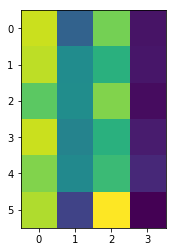

In [15]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 36.93%, category clustering: 29.59%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 36.40%, category clustering: 55.00%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 41.44%, category clustering: 6.22%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 37.93%, category clustering: 8.92%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 33.33%, category clustering: 0.14%
cluster: 5 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 47.67%, weighted: 37.09%


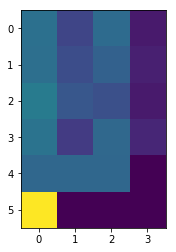

In [16]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

best weighted score: 38.99%, number of clusters: 9
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 36.94%, category clustering: 29.05%
cluster: 1 --> top category: V-Pet, frequency of category (variety within cluster): 37.44%, category clustering: 12.73%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 36.88%, category clustering: 53.38%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 44.87%, category clustering: 4.73%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 37.50%, category clustering: 1.62%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.62%
cluster: 6 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.31%
cluster: 7 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, catego

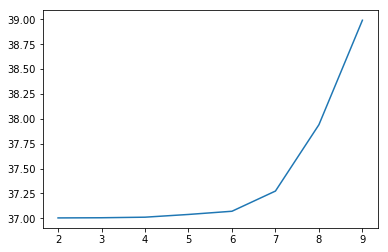

In [17]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

best weighted score: 37.72%, number of clusters: 7
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 39.15%, category clustering: 24.86%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 35.78%, category clustering: 62.03%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 43.18%, category clustering: 5.14%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 35.81%, category clustering: 7.16%
cluster: 4 --> top category: V-Auto, frequency of category (variety within cluster): 50.00%, category clustering: 0.67%
cluster: 5 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.54%
cluster: 6 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 57.70%, weighted: 37.72%


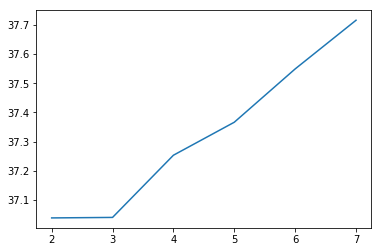

In [18]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

best weighted score: 38.60%, number of clusters: 7
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 37.06%, category clustering: 98.65%
cluster: 1 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.93%
cluster: 2 --> top category: V-Pet, frequency of category (variety within cluster): 66.67%, category clustering: 0.62%
cluster: 3 --> top category: V-Auto, frequency of category (variety within cluster): 50.00%, category clustering: 0.67%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.54%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 100.00%, category clustering: 0.16%
cluster: 6 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 71.96%, weighted: 38.60%


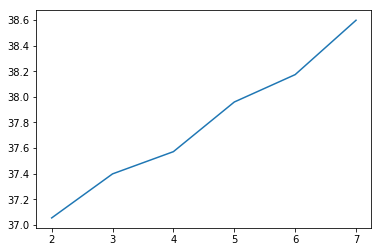

In [19]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [204]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

{0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}


run=1 tscore=0.34618 vscore=0.371571
run=2 tscore=0.34618 vscore=0.371571
run=3 tscore=0.34618 vscore=0.371571
run=4 tscore=0.34618 vscore=0.371571
run=5 tscore=0.34618 vscore=0.371571
run=6 tscore=0.34618 vscore=0.371571
run=7 tscore=0.34618 vscore=0.371571
run=8 tscore=0.557809 vscore=0.600998
run=9 tscore=0.597025 vscore=0.61596
run=10 tscore=0.617309 vscore=0.608479
run=11 tscore=0.617985 vscore=0.613466
run=12 tscore=0.618661 vscore=0.610973
run=13 tscore=0.621366 vscore=0.610973
run=14 tscore=0.620014 vscore=0.613466
run=15 tscore=0.622718 vscore=0.610973
run=16 tscore=0.622718 vscore=0.610973
run=17 tscore=0.622718 vscore=0.610973
run=18 tscore=0.628803 vscore=0.608479
run=19 tscore=0.630156 vscore=0.603491
run=20 tscore=0.634212 vscore=0.608479
run=21 tscore=0.635565 vscore=0.613466
run=22 tscore=0.638945 vscore=0.61596
run=23 tscore=0.640974 vscore=0.618454
run=24 tscore=0.638945 vscore=0.613466
run=25 tscore=0.636241 vscore=0.605985
run=26 tscore=0.638945 vscore=0.605985
run=

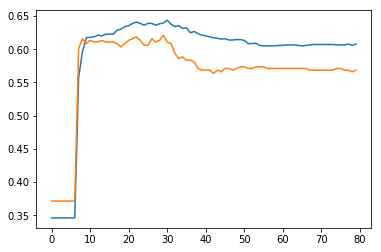

In [210]:
my_perc.train(X, y, percentage=0.8, std=True, loss='hinge', penalty='none', alpha=1e-6,
          power_t=0.7, max_iter=8000, it_interval=100, learning_rate='constant', eta0=1e-6,
          threshold_unbalanced=0.6, class_weight={2: 2.00, 1: 1.55, 0: 4.50})

In [84]:
my_perc.predict(X,y)

array([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1.])

In [213]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

run=1 tscore=0.353303 vscore=0.292614
run=2 tscore=0.357911 vscore=0.286932
run=3 tscore=0.368664 vscore=0.286932
run=4 tscore=0.372504 vscore=0.292614
run=5 tscore=0.378648 vscore=0.306818
run=6 tscore=0.378648 vscore=0.303977
run=7 tscore=0.380952 vscore=0.3125
run=8 tscore=0.380952 vscore=0.318182
run=9 tscore=0.379416 vscore=0.321023
run=10 tscore=0.380184 vscore=0.326705
run=11 tscore=0.387865 vscore=0.332386
run=12 tscore=0.394777 vscore=0.335227
run=13 tscore=0.396313 vscore=0.340909
run=14 tscore=0.397849 vscore=0.34375
run=15 tscore=0.400154 vscore=0.340909
run=16 tscore=0.404762 vscore=0.346591
run=17 tscore=0.410906 vscore=0.346591
run=18 tscore=0.410138 vscore=0.346591
run=19 tscore=0.412442 vscore=0.352273
run=20 tscore=0.414747 vscore=0.357955
run=21 tscore=0.414747 vscore=0.357955
run=22 tscore=0.418587 vscore=0.363636
run=23 tscore=0.417819 vscore=0.363636
run=24 tscore=0.419355 vscore=0.366477
run=25 tscore=0.423195 vscore=0.363636
run=26 tscore=0.427803 vscore=0.37215

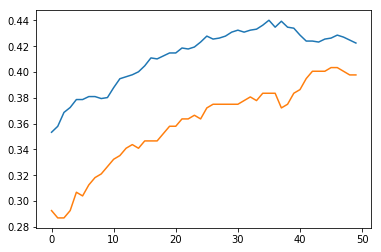

In [214]:
my_perc.train(X, y, percentage=0.8, std=False, loss='hinge', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=5000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight=None)

In [197]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

run=1 tscore=0.017331 vscore=0.0201342
run=2 tscore=0.017331 vscore=0.0201342
run=3 tscore=0.017331 vscore=0.0201342
run=4 tscore=0.017331 vscore=0.0201342
run=5 tscore=0.017331 vscore=0.0201342
run=6 tscore=0.017331 vscore=0.0201342
run=7 tscore=0.017331 vscore=0.0201342
run=8 tscore=0.017331 vscore=0.0201342
run=9 tscore=0.017331 vscore=0.0201342
run=10 tscore=0.017331 vscore=0.0201342
run=11 tscore=0.017331 vscore=0.0201342
run=12 tscore=0.017331 vscore=0.0201342
run=13 tscore=0.017331 vscore=0.0201342
run=14 tscore=0.017331 vscore=0.0201342
run=15 tscore=0.017331 vscore=0.0201342
run=16 tscore=0.017331 vscore=0.0201342
run=17 tscore=0.017331 vscore=0.0201342
run=18 tscore=0.017331 vscore=0.0201342
run=19 tscore=0.017331 vscore=0.0234899
run=20 tscore=0.017331 vscore=0.0234899
run=21 tscore=0.017331 vscore=0.0234899
run=22 tscore=0.0181976 vscore=0.0268456
run=23 tscore=0.0207972 vscore=0.0268456
run=24 tscore=0.0225303 vscore=0.0268456
run=25 tscore=0.0259965 vscore=0.033557
run=26

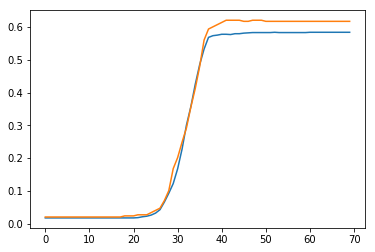

In [201]:
my_perc.train(X, y, percentage=0.8, std=True, loss='log', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=7000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight=None)

In [185]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

['0.2' '0.1' '0.3' '0.0' nan '0.5' '0.6' '0.4' '0.7' '0.9' '0.8' '1.0']


run=1 tscore=0.000777001 vscore=0
run=2 tscore=0.000777001 vscore=0
run=3 tscore=0.001554 vscore=0
run=4 tscore=0.002331 vscore=0
run=5 tscore=0.003108 vscore=0
run=6 tscore=0.00621601 vscore=0
run=7 tscore=0.00854701 vscore=0.0114613
run=8 tscore=0.010101 vscore=0.0114613
run=9 tscore=0.013209 vscore=0.017192
run=10 tscore=0.017871 vscore=0.025788
run=11 tscore=0.02331 vscore=0.0372493
run=12 tscore=0.032634 vscore=0.0429799
run=13 tscore=0.039627 vscore=0.0573066
run=14 tscore=0.0512821 vscore=0.0630372
run=15 tscore=0.0668221 vscore=0.0687679
run=16 tscore=0.0924631 vscore=0.0916905
run=17 tscore=0.118104 vscore=0.117479
run=18 tscore=0.148407 vscore=0.157593
run=19 tscore=0.177933 vscore=0.166189
run=20 tscore=0.191142 vscore=0.180516
run=21 tscore=0.199689 vscore=0.189112
run=22 tscore=0.204351 vscore=0.200573
run=23 tscore=0.20979 vscore=0.203438
run=24 tscore=0.214452 vscore=0.206304
run=25 tscore=0.219114 vscore=0.209169
run=26 tscore=0.223776 vscore=0.209169
run=27 tscore=0.22

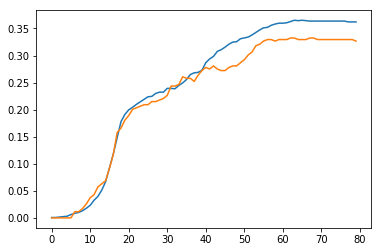

In [196]:
my_perc.train(X, y, percentage=0.8, std=False, loss='hinge', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=8000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight=None)